In [331]:
import numpy as np
import math
import pandas as pd
# from sqlalchemy import create_engine
import time
import copy
import matplotlib.pyplot as plt

def load_data(user_id):
    '''


    elements = pd.read_sql('elements', engine)
    elements = elements.loc[elements['user_id'] == user_id]
    truss_elements = elements.loc[elements['elem_type'] == 'truss']
    nodes = pd.read_sql('nodes', engine)
    nodes = nodes.loc[nodes['user_id'] == user_id]
    sections = pd.read_sql('sections', engine)
    sections = sections.loc[sections['user_id'] == user_id]
    point_loads = pd.read_sql('point_loads', engine)
    point_loads = point_loads.loc[point_loads['user_id'] == user_id]
    dist_loads = pd.read_sql('dist_loads', engine)
    dist_loads = dist_loads.loc[dist_loads['user_id'] == user_id]

    elements.to_csv('model_test/elements.csv', index=False)
    truss_elements.to_csv('model_test/truss_elements.csv', index=False)
    nodes.to_csv('model_test/nodes.csv', index=False)
    sections.to_csv('model_test/sections.csv', index=False)
    point_loads.to_csv('model_test/point_loads.csv', index=False)
    dist_loads = dist_loads.to_csv('model_test/dist_loads.csv', index=False)
    '''

    elements = pd.read_csv('model_test/test_1/elements.csv')
    truss_elements = pd.read_csv('model_test/test_1/truss_elements.csv')
    nodes = pd.read_csv('model_test/test_1/nodes.csv')
    sections = pd.read_csv('model_test/test_1/sections.csv')
    point_loads = pd.read_csv('model_test/test_1/point_loads.csv')
    dist_loads = pd.read_csv('model_test/test_1/dist_loads.csv')

    return elements, nodes, sections, point_loads, dist_loads, truss_elements


# calculate DOFS
def dofs(nodes):
    t1 = time.time()
    nodes_n = len(nodes)
    #   #get 1D array of the constraints
    constraints = nodes.iloc[:, [6, 7, 8, 9, 10, 11]].get_values().flatten(order='C')
    #   #argsort returns the indexes to sort the constraints to free and sup
    dofs = constraints.argsort()
    node_dofs = pd.DataFrame(np.reshape(np.sort(dofs), (nodes_n, 6)))
    node_dofs['nn'] = nodes['nn']
    node_dofs.columns = ['dofx', 'dofy', 'dofz', 'dofrx', 'dofry', 'dofrz', 'nn']
    a = constraints[constraints.argsort()]
    temp = np.where(a == 0)
    slice = temp[0][len(temp[0]) - 1] + 1
    sup_dofs = sorted(dofs[:slice].tolist())
    free_dofs = sorted(dofs[slice:].tolist())
    arranged_dofs = free_dofs + sup_dofs
    print('DOFS: ', time.time() - t1)
    return arranged_dofs, free_dofs, sup_dofs, node_dofs


def stifness_array(dofs, elements, nodes, sections, node_dofs, truss_elements):
    t1 = time.time()
    local_stifness = []
    transf_arrays = []
    step = len(nodes) * 6
    K_ol = np.zeros((step, step))
    for index, elm in elements.iterrows():
        nodei = nodes.loc[nodes.nn == elm.nodei]
        nodej = nodes.loc[nodes.nn == elm.nodej]
        sect = sections.loc[sections.section_id == elm.section_id]
        k = local_stif(elm, sect)
        local_stifness.append(k.copy())
        rot = transformation_array(elm, nodei, nodej)
        transf_arrays.append(rot.copy())
        t = np.transpose(rot).dot(k).dot(rot)
        i = nodei.nn.get_values()[0]
        j = nodej.nn.get_values()[0]
        if elm.elem_type == 'beam':
            dofs_i = node_dofs.loc[node_dofs.nn == i]
            dofs_j = node_dofs.loc[node_dofs.nn == j]
            dof_a, dof_b = dofs_i['dofx'].get_values()[0], \
                           dofs_i['dofrz'].get_values()[0] + 1
            dof_c, dof_d = dofs_j['dofx'].get_values()[0], \
                           dofs_j['dofrz'].get_values()[0] + 1
            K_ol[dof_a:dof_b, dof_a:dof_b] += t[:6, :6]
            K_ol[dof_a:dof_b, dof_c:dof_d] += t[:6, 6:]
            K_ol[dof_c:dof_d, dof_a:dof_b] += t[6:, :6]
            K_ol[dof_c:dof_d, dof_c:dof_d] += t[6:, 6:]
        else:
            dof_a, dof_b = node_dofs.loc[node_dofs.nn == nodei.nn]['dofx'].get_values()[0], \
                           node_dofs.loc[node_dofs.nn == nodei.nn]['dofz'].get_values()[0] + 1
            dof_c, dof_d = node_dofs.loc[node_dofs.nn == nodej.nn]['dofx'].get_values()[0], \
                           node_dofs.loc[node_dofs.nn == nodej.nn]['dofz'].get_values()[0] + 1
            K_ol[dof_a:dof_b, dof_a:dof_b] += t[:3, :3]
            K_ol[dof_a:dof_b, dof_c:dof_d] += t[:3, 3:]
            K_ol[dof_c:dof_d, dof_a:dof_b] += t[3:, :3]
            K_ol[dof_c:dof_d, dof_c:dof_d] += t[3:, 3:]

    # i_uper = np.triu_indices(step, 0)

    # K_ol[i_uper] = K_ol.T[i_uper]
    print('arrays: ', time.time() - t1)
    return local_stifness, transf_arrays, K_ol


def local_stif(element, sect):
    L = element.length
    elem_type = element.elem_type

    # A, E = sect.A, sect.E
    A = 0.027777777777777773  # 0.2090318
    E = sect.E.get_values()[0]  # 200000000  # 199948023.75
    if elem_type == 'beam':
        Iy, Iz, G, J = sect.Ix.get_values()[0], sect.Iy.get_values()[0], sect.G.get_values()[0], sect.Iz.get_values()[0]
        # Iy = 64300411.522633724e-12  # 0.00364
        # Iz = 64300411.522633724 * 10 ** -12  # 0.00364
        G = E / 2 / 1.27  # 76904146.79
        # J = 108506944.4444444 * 10 ** -12  # 0.00614
        
        w1 = E * A / L
        print(1000*63.56439*1.2/E/A)
        w2 = 12 * E * Iz / (L * L * L)
        w3 = 6 * E * Iz / (L * L)
        w4 = 4 * E * Iz / L
        w5 = 2 * E * Iz / L
        w6 = 12 * E * Iy / (L * L * L)
        w7 = 6 * E * Iy / (L * L)
        w8 = 4 * E * Iy / L
        w9 = 2 * E * Iy / L
        w10 = G * J / L

        y = np.zeros((12, 12))
        # creates half the stifness matrix
        y[0, 0] = w1
        y[6, 0] = -w1
        y[1, 1] = w2
        y[5, 1] = w3
        y[7, 1] = -w2
        y[11, 1] = w3
        y[2, 2] = w6
        y[4, 2] = -w7
        y[8, 2] = -w6
        y[10, 2] = -w7
        y[3, 3] = w10
        y[9, 3] = -w10
        y[4, 4] = w8
        y[8, 4] = w7
        y[10, 4] = w9
        y[5, 5] = w4
        y[11, 5] = w5
        y[6, 6] = w1
        y[7, 5] = w7
        y[7, 7] = w2
        y[11, 7] = -w3
        y[8, 8] = w6
        y[10, 8] = w7
        y[9, 9] = w10
        y[10, 10] = w8
        y[11, 11] = w4

        y = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                      [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                      [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                      [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                      [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                      [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                      [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                      [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                      [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                      [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                      [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                      [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])

        # y = np.round(y, precision)

    else:
        w1 = E * A / L
        y = np.array([[w1, 0, 0, -w1, 0, 0],
                      [0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0],
                      [-w1, 0, 0, w1, 0, 0],
                      [0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0]])

    return y


def transformation_array(element, nodei, nodej):
    L = element.length
    i, j = element.nodei, element.nodej

    x1, x2 = nodei.coord_x.get_values()[0], nodej.coord_x.get_values()[0]
    y1, y2 = nodei.coord_y.get_values()[0], nodej.coord_y.get_values()[0]
    z1, z2 = nodei.coord_z.get_values()[0], nodej.coord_z.get_values()[0]
    # need to find what works for the random case
    #

    CXx = (x2 - x1) / L
    CYx = (y2 - y1) / L
    CZx = (z2 - z1) / L

    if CZx == 0:
        xR, yR, zR = 0, 110000, 0
    else:
        xR, yR, zR = 0, 110000, 0

    Lambda = np.zeros((3, 3))
    if element.elem_type == 'beam':
        if CXx == 0 and CZx == 0:
            Y = -xR + x1
            Z = zR - z1
            if y1 > y2:
                Y = -Y

        else:
            SQ = math.sqrt(CXx * CXx + CZx * CZx)
            Y = -CXx * CYx * (xR - x1) / SQ + SQ * (yR - y1) - CYx * CZx * (zR - z1) / SQ
            Z = -CZx * (xR - x1) / SQ + CXx * (zR - z1) / SQ

        SQyz = math.sqrt(Y * Y + Z * Z)
        SINY = Z / SQyz
        COSY = Y / SQyz

        Lambda[0, 0] = CXx
        Lambda[0, 1] = CYx
        Lambda[0, 2] = CZx
        if CXx == 0 and CZx == 0:

            Lambda[1, 0] = -COSY
            Lambda[1, 1] = 0
            Lambda[1, 2] = SINY
            Lambda[2, 0] = SINY
            Lambda[2, 1] = 0
            Lambda[2, 2] = COSY
            if y1 >= y2:
                Lambda[1, 0] = COSY
                Lambda[2, 0] = -SINY
        else:
            Lambda[1, 0] = -(CXx * CYx * COSY + CZx * SINY) / SQ
            Lambda[1, 1] = SQ * COSY
            Lambda[1, 2] = -(CYx * CZx * COSY - CXx * SINY) / SQ
            Lambda[2, 0] = (CXx * CYx * SINY - CZx * COSY) / SQ
            Lambda[2, 1] = -SQ * SINY
            Lambda[2, 2] = (CYx * CZx * SINY + CXx * COSY) / SQ

    LAMDA = np.zeros((12, 12))
    zeroes = np.array([0, 0, 0])

    LAMDA[:3, :3], LAMDA[3:6, 3:6] = Lambda, Lambda
    LAMDA[6:9, 6:9], LAMDA[9:, 9:] = Lambda, Lambda
    return LAMDA


def nodal_forces(point_loads, dist_loads, node_dofs, tranf_arrays, arranged_dofs, elements):
    P_nodal = np.zeros((len(arranged_dofs), 1))
    S = np.zeros((len(arranged_dofs), 1))
    fixed_forces = np.zeros((12, len(elements)))
    # diaforopoiisi gia truss elements
    for index, load in point_loads.iterrows():
        A_i = np.zeros((6, 1))
        A_j = np.zeros((6, 1))
        if load.c == 99999:
            node = load.nn
            a, b = node_dofs.loc[node_dofs.nn == node]['dofx'].get_values()[0], \
                   node_dofs.loc[node_dofs.nn == node]['dofrz'].get_values()[0] + 1
            P_nodal[a:b] += [[load.p_x], [load.p_y], [load.p_z],
                             [load.m_x], [load.m_y], [load.m_z]]
        else:
            elm_id = load.nn
            elm = elements.loc[elements.en == elm_id]
            L = elm.length.get_values()[0]
            nodei = elm.nodei.get_values()[0]
            nodej = elm.nodej.get_values()[0]
            dofa, dofb = node_dofs.loc[node_dofs.nn == nodei]['dofx'].get_values()[0], \
                         node_dofs.loc[node_dofs.nn == nodei]['dofrz'].get_values()[0] + 1
            dofc, dofd = node_dofs.loc[node_dofs.nn == nodej]['dofx'].get_values()[0], \
                         node_dofs.loc[node_dofs.nn == nodej]['dofrz'].get_values()[0] + 1
            a = load.c * L
            b = (1 - load.c) * L
            # add the appropriate moment loads
            p = load.iloc[[4, 5, 6, 7, 8, 9]].get_values()
            A_i[0] = -p[0] * (1 - load.c)  # Fx_i
            A_j[0] = -p[0] * load.c  # Fx_j
            A_i[1] = -p[1] * (b / L - a ** 2 * b / L ** 3 + a * b ** 2 / L ** 3)  # Fy_i
            A_j[1] = -p[1] * (a / L + a ** 2 * b / L ** 3 - a * b ** 2 / L ** 3)  # Fy_j
            A_i[2] = -p[2] * (b / L - a ** 2 * b / L ** 3 + a * b ** 2 / L ** 3)  # Fz_i
            A_j[2] = -p[2] * (a / L + a ** 2 * b / L ** 3 - a * b ** 2 / L ** 3)  # Fz_j
            A_i[3] = -p[3] * (1 - load.c)  # Mx_i
            A_j[3] = -p[3] * load.c  # Mx_j
            A_i[4] = p[2] * a * b ** 2 / L ** 2  # My_i
            A_j[4] = -p[2] * a ** 2 * b / L ** 2  # My_j
            A_i[5] = -p[1] * a * b ** 2 / L ** 2  # Mz_i
            A_j[5] = p[1] * a ** 2 * b / L ** 2  # Mz_j

            # element forces from to local to global

            rot = tranf_arrays[elm.index[0]][:6, :6]
            S[dofa:dofb] += np.transpose(rot).dot(A_i)
            S[dofc:dofd] += np.transpose(rot).dot(A_j)
            fixed_forces[:6, elm.index[0]] = np.reshape(A_i, 6)
            fixed_forces[6:, elm.index[0]] = np.reshape(A_j, 6)

    # approaching dist loads adding two triangle loads: (p1,0) + (0,p2)0
    for index, d_load in dist_loads.iterrows():
        A_i = np.zeros((6, 1))
        A_j = np.zeros((6, 1))
        elm_id = d_load.en
        elm = elements.loc[elements.en == elm_id]
        L = elm.length.get_values()[0]
        nodei = elm.nodei.get_values()[0]
        nodej = elm.nodej.get_values()[0]
        dofa, dofb = node_dofs.loc[node_dofs.nn == nodei]['dofx'].get_values()[0], \
                     node_dofs.loc[node_dofs.nn == nodei]['dofrz'].get_values()[0] + 1
        dofc, dofd = node_dofs.loc[node_dofs.nn == nodej]['dofx'].get_values()[0], \
                     node_dofs.loc[node_dofs.nn == nodej]['dofrz'].get_values()[0] + 1

        p = d_load.iloc[[3, 4, 5, 6, 7, 8]].get_values()
        a = d_load.c * L
        b = d_load.l * L
        c = b - a
        d1 = L - a - 2 * c / 3
        d2 = L - a - c / 3
        f1 = 1 - d1 / L
        f2 = 1 - d2 / L
        # Fx
        # Fxi
        F1_i = p[0] * c / 2 * d1 / L
        F2_i = p[1] * c / 2 * d2 / L
        A_i[0] = -(F1_i + F2_i)
        # Fxj
        F1_j = p[0] * c / 2 * (1 - d1 / L)
        F2_j = p[1] * c / 2 * (1 - d2 / L)
        A_j[0] = -(F1_j + F2_j)
        # Fy
        # Fyi
        F1_i = p[2] * c / 2 / L ** 3 * (d1 ** 2 * (3 * L - 2 * d1) - c ** 2 / 3 * (L / 2 - b + 17 / 45 * c))
        F2_i = p[3] * c / 2 - F1_i
        A_i[1] = -(F1_i + F2_i)
        # Fyj
        F2_j = p[2] * c / 2 / L ** 3 * (d2 ** 2 * (3 * L - 2 * d2) - c ** 2 / 3 * (L / 2 - b + 17 / 45 * c))
        F1_j = p[3] * c / 2 - F2_j
        A_j[1] = -(F1_j + F2_j)

        A_i[0] = -p[0] * c / 2 * d1 / L - p[1] * c / 2 * d2 / L  # Fx_i
        A_j[0] = -p[0] * c / 2 * f1 - p[1] * c / 2 * f2  # Fx_j
        A_i[1] = -p[2] * c / 2 / L ** 3 * (d1 ** 2 * (3 * L - 2 * d1) - c ** 2 / 3 * (L / 2 - b + 17 / 45 * c)) + p[
            3] * c / 2 - p[3] * c / 2 / L ** 3 * (
                         d2 ** 2 * (3 * L - 2 * d2) - c ** 2 / 3 * (L / 2 - b + 17 / 45 * c))  # Fy_i
        A_j[1] = -p[2] * c / 2 - p[3] * c / 2 - A_i[1]  # Fy_j
        A_i[2] = -p[4] * c * (d1 ** 2 * (3 * L - 2 * d1) - c ** 2 / 3 * (L / 2 - b + 17 / 45 * c)) / 2 / L ** 3 - p[
            5] * c * (d2 ** 2 * (3 * L - 2 * d2) - c ** 2 / 3 * (L / 2 - b + 17 / 45 * c)) / 2 / L ** 3  # Fz_i
        A_j[2] = -p[4] * c / 2 - p[5] * c / 2 - A_i[2]  # Fz_j
        A_i[3] = 0  # Mx_i
        A_j[3] = 0  # Mx_j
        A_i[4] = -p[4] * c * (d1 ** 2 * (d1 - L) + c ** 2 * (L / 3 + 17 * c / 90 - b / 2) / 3) / 2 / L ** 2 - p[
            5] * c * (d2 ** 2 * (d2 - L) + c ** 2 * (L / 3 + 17 * c / 90 - b / 2) / 3) / 2 / L ** 2  # My_i
        A_j[4] = -p[4] * c * (d1 * (d1 - L) ** 2 + c ** 2 * (L / 3 + 17 * c / 45 - b) / 6) / 2 / L ** 2 - p[5] * c * (
                d2 * (d2 - L) ** 2 + c ** 2 * (L / 3 + 17 * c / 45 - b) / 6) / 2 / L ** 2  # My_j
        A_i[5] = -p[2] * c * (d1 ** 2 * (d1 - L) + c ** 2 * (L / 3 + 17 * c / 90 - b / 2) / 3) / 2 / L ** 2 - p[
            3] * c * (d2 ** 2 * (d2 - L) + c ** 2 * (L / 3 + 17 * c / 90 - b / 2) / 3) / 2 / L ** 2  # Mz_i
        A_j[5] = -p[2] * c * (d1 * (d1 - L) ** 2 + c ** 2 * (L / 3 + 17 * c / 45 - b) / 6) / 2 / L ** 2 - p[3] * c * (
                d2 * (d2 - L) ** 2 + c ** 2 * (L / 3 + 17 * c / 45 - b) / 6) / 2 / L ** 2  # Mz_j

        # rot = tranf_arrays[elm.index[0]][:6, :6]
        # S[dofa:dofb] += np.transpose(rot).dot(A_i)
        # S[dofc:dofd] += np.transpose(rot).dot(A_j)
        # fixed_forces[:6, elm.index[0]] = np.reshape(A_i, 6)
        # fixed_forces[6:, elm.index[0]] = np.reshape(A_j, 6)

    return P_nodal, S, fixed_forces


def solver(K, P_nodal, dofs, dofs_arranged, free, S):
    # rearagment of the arrays
    K_m = rearrangment(K, dofs_arranged)
    P_m = rearrangment(P_nodal, dofs_arranged)
    S_m = rearrangment(S, dofs_arranged)

    P_f = P_m[:free] - S_m[:free]

    Kff = K_m[:free, :free]
    Ksf = K_m[free:, :free]

    D_f = np.linalg.inv(Kff).dot(P_f)
    P_s = np.dot(Ksf, D_f) + S_m[free:]

    D = np.zeros((len(dofs), 1))
    i = 0
    for r in dofs_arranged[:free]:
        D[r] = D_f[i]
        i += 1

    return P_s, D


def rearrangment(array, dofs):
    step = len(dofs)
    anad = np.zeros((step, step))
    for i in range(len(dofs)):
        anad[i, dofs[i]] = 1
    if array.shape[1] == 1:
        a = anad.dot(array)
    else:
        a = anad.dot(array).dot(np.transpose(anad))

    return a


def nodal_mqn(K, Lamda, displacments, elements, node_dofs, S, nodes, point_loads, fixed_forces):
    mqn = []
    disp_local = []
    for index, elm in elements.iterrows():
        i = index

        sect = None
        nodei = nodes.loc[nodes.nn == elm.nodei]
        nodej = nodes.loc[nodes.nn == elm.nodej]
        k = K[index]

        rot = Lamda[index]

        nodei = elm.nodei
        nodej = elm.nodej

        a, b = node_dofs.loc[node_dofs.nn == nodei]['dofx'].get_values()[0], \
               node_dofs.loc[node_dofs.nn == nodei]['dofrz'].get_values()[0] + 1
        c, d = node_dofs.loc[node_dofs.nn == nodej]['dofx'].get_values()[0], \
               node_dofs.loc[node_dofs.nn == nodej]['dofrz'].get_values()[0] + 1
        d_elem = np.zeros((12, 1))
        d_elem[:6], d_elem[6:] = displacments[a:b], displacments[c:d]
        # local displacments
        d_local = rot.dot(d_elem)
        
        
        MQN = k.dot(d_local)
        MQN[:6, 0] += fixed_forces[:6, index]
        MQN[6:, 0] += fixed_forces[6:, index]
        # need to add nodal forces from fixed elements
        mqn.append(MQN)
        disp_local.append(d_local)
    return mqn, disp_local


def rotate_loads(elements, point_loads, dist_loads, transf_arrays):
    for index, element in elements.iterrows():
        L = element.length

        # transform the loads here, its easier
        p_load = point_loads.loc[(point_loads.nn == element.en) & (point_loads.c != 99999)]
        d_load = dist_loads.loc[(dist_loads.en == element.en)]
        if not p_load.empty:
            P_x = np.array([p_load.p_x.get_values()[0], 0, 0])
            P_y = np.array([0, p_load.p_y.get_values()[0], 0])
            P_z = np.array([0, 0, p_load.p_z.get_values()[0]])

            rot = transf_arrays[index][:3, :3]
            p = rot.dot(P_x) + rot.dot(P_y) + rot.dot(P_z)
            # p =

            # .p_x,  point_loads.iloc[p_load.index].p_y,  point_loads.iloc[p_load.index].p_z = p[0], p[1], p[2]
            p_load['p_x'], p_load['p_y'], p_load['p_z'] = p[0], p[1], p[2]
            point_loads.iloc[p_load.index, :] = p_load
        if not d_load.empty:
            rot = transf_arrays[index][:3, :3]
            p_1_x = [d_load.p_1_x.get_values()[0], 0, 0]
            p_2_x = [d_load.p_2_x.get_values()[0], 0, 0]

            p_1_y = [0, d_load.p_1_y.get_values()[0], 0]
            p_2_y = [0, d_load.p_2_y.get_values()[0], 0]
            p_1_z = [0, 0, d_load.p_1_z.get_values()[0]]
            p_2_z = [0, 0, d_load.p_2_z.get_values()[0]]
            p_1 = rot.dot(p_1_x) + rot.dot(p_1_y) + rot.dot(p_1_z)
            p_2 = rot.dot(p_2_x) + rot.dot(p_2_y) + rot.dot(p_2_z)
            d_load['p_1_x'], d_load['p_1_y'], d_load['p_1_z'] = p_1[0], p_1[1], p_1[2]
            d_load['p_2_x'], d_load['p_2_y'], d_load['p_2_z'] = p_2[0], p_2[1], p_2[2]
            dist_loads.iloc[d_load.index, :] = d_load
    print(point_loads)
    return point_loads, dist_loads


def mqn_member(elements, MQN_nodes, d_local, sections, point_loads, dist_loads):
    # MQN_values = []
    MQN_values = pd.DataFrame([], columns=['en', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'x'])
    points = 20

    for index, element in elements.iterrows():
        mqn_nodes = MQN_nodes[index]
        disp = d_local[index]
        mqn_values = np.zeros((points, 8))
        disp_member_local = np.zeros((8, points))
        L = element.length

        p_load = point_loads.loc[(point_loads.nn == element.en) & (point_loads.c != 99999)]
        d_load = dist_loads.loc[(dist_loads.en == element.en)]
        # MQN for Point Loads
        if not p_load.empty:
            c = L * p_load.c.get_values()
            # length
            # separate x around c
            temp = 10
            x1 = np.linspace(0, c, temp, endpoint=False)
            x2 = np.linspace(c, L, temp)
            x = np.unique(np.concatenate((x1, x2), axis=0))

            mqn_values[:points, 0] = element.en
            mqn_values[:points, -1] = x

            # Fx
            mqn_values[:temp, 1].fill(mqn_nodes[0, 0])
            mqn_values[temp:, 1].fill(-mqn_nodes[6, 0])
            # Fy
            mqn_values[:temp, 2].fill(mqn_nodes[1, 0])
            mqn_values[temp:, 2].fill(-mqn_nodes[7, 0])
            # Fz
            mqn_values[:temp, 3].fill(mqn_nodes[2, 0])
            mqn_values[temp:, 3].fill(-mqn_nodes[8, 0])
            # Mx
            mqn_values[:temp, 4].fill(mqn_nodes[3, 0])
            mqn_values[temp:, 4].fill(-mqn_nodes[9, 0])
            # My
            mqn_values[:temp, 5] = mqn_nodes[2, 0] * x1 + mqn_nodes[4, 0]  # - p_load.p_z.get_values()*c*(1-c)**2/L**2
            mqn_values[temp:, 5] = mqn_nodes[2, 0] * x2 + mqn_nodes[
                4, 0] - p_load.p_z.get_values() * c + p_load.p_z.get_values() * x2
            # Mz
            mqn_values[:temp, 6] = mqn_nodes[1, 0] * x1 - mqn_nodes[5, 0]  # - p_load.p_z.get_values()*c*(1-c)**2/L**2
            mqn_values[temp:, 6] = mqn_nodes[1, 0] * x2 - mqn_nodes[
                5, 0] - p_load.p_y.get_values() * c + p_load.p_y.get_values() * x2

        else:
            mqn_values[:points, 0] = element.en
            x = np.linspace(0, L, points)
            mqn_values[:points, -1] = x
            temp = 10

            # Fx
            mqn_values[:temp, 1].fill(mqn_nodes[0, 0])
            mqn_values[temp:, 1].fill(-mqn_nodes[6, 0])
            # Fy
            mqn_values[:temp, 2].fill(mqn_nodes[1, 0])
            mqn_values[temp:, 2].fill(-mqn_nodes[7, 0])
            # Fz
            mqn_values[:temp, 3].fill(mqn_nodes[2, 0])
            mqn_values[temp:, 3].fill(-mqn_nodes[8, 0])
            # Mx
            mqn_values[:temp, 4].fill(mqn_nodes[3, 0])
            mqn_values[temp:, 4].fill(-mqn_nodes[9, 0])
            # My
            mqn_values[:, 5] = mqn_nodes[2, 0] * x + mqn_nodes[4, 0]
            # mqn_values[temp:, 5] = mqn_nodes[10, 0]
            # Mz
            mqn_values[:, 6] = mqn_nodes[1, 0] * x - mqn_nodes[5, 0]
            
        df = pd.DataFrame(mqn_values, columns=['en', 'Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'x'])
        MQN_values = pd.concat([MQN_values, df], axis=0).reset_index(drop=True)
        # MQN_values.append(mqn_values)
    return MQN_values

def displ_member(nodes, elements, local_displacements, global_dispalecements, transf_arrays):
    import plotly.plotly as py
    import plotly.graph_objs as go
    trace2 = go.Scatter3d(
            x=[0,3,5], y=[0,2,4], z=[0,3,2],
            marker=dict(
                size=1,
            ),
            line=dict(
                color='#1f77b4',
                width=1.5
            )
        )

    data = [trace2]
    n = 50
    D_LOCAL = pd.DataFrame([], columns=['en', 'x', 'u_y', 'u_z'])
    D_GLOBAL = pd.DataFrame([], columns=['en', 'x', 'u_y', 'u_z'])
    for index, element in elements.iterrows():
        #local displacements
        
        node_i = nodes.loc[nodes.nn == int(element.nodei)]
        node_j = nodes.loc[nodes.nn == int(element.nodej)]
        rot = transf_arrays[index][:3]
        d_local = np.zeros((n, 4))
        L = element.length
        x = np.linspace(0, L, n)
        
        # z
        d = local_displacements[index]
        m2_A = np.transpose(d[:6])[0]
        m2_B = np.transpose(d[6:])[0]
        
        # test sto z
        dx = 0.1
        xA = 0
        yA = m2_A[2]
        xA_ = dx
        yA_ = dx*math.tan(m2_A[4])
        xB = L
        yB = m2_B[2]
        xB_ = L-dx
        yB_ = yB + dx*math.tan(m2_B[4])
        # fit me 3rd order polyonimial
        coef = np.polyfit([xA, xA_, xB, xB_], [yA, yA_, yB, yB_], 3)
        d_z = x**3*coef[0]+x**2*coef[1]+x*coef[2]+coef[3]
                      
        # y
        dx = 0.08
        xA = 0
        yA = m2_A[1]
        xA_ = dx
        yA_ = yA + dx*math.tan(m2_A[5])
        xB = L
        yB = m2_B[1]
        xB_ = L-dx
        yB_ = yB - dx*math.tan(m2_B[5])
        # fit me 3rd order polyonimial
        coef = np.polyfit([xA, xA_, xB_, xB ], [yA, yA_, yB_, yB], 3)
        d_y= x**3*coef[0]+x**2*coef[1]+x*coef[2]+coef[3]
        
        d_local[:, 0] = index+1
        d_local[:, 1] = x
        d_local[:, 2] = 10*d_y
        d_local[:, 3] = 10*d_z
        
        temp = np.transpose(rot).dot(np.transpose(d_local[:,1:]))
        
        import matplotlib as mpl
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
       
        mpl.rcParams['legend.fontsize'] = 10

        fig = plt.figure()
        ax = fig.gca(projection='3d')
        theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
        if index>0:
            z = temp[2]+L
            x = x+L
            y = temp[1]+L
        else:
            z = temp[2]
            x = x
            y = temp[1]
        #x, y, z = global_displacements['x'], global_displacements['u_y'], global_displacements['u_z']
       
        #plt.show()

        df = pd.DataFrame(d_local, columns=['en', 'x', 'u_y', 'u_z'])
        D_LOCAL = pd.concat([D_LOCAL, df], axis=0).reset_index(drop=True)
        
        #
        # global dispalecements
        #
        nn_i = int(node_i.nn.get_values())
        nn_j = int(node_j.nn.get_values())
        # find the line coordinates x
        # direction vector
        x1, x2 = node_i.coord_x.get_values()[0], node_j.coord_x.get_values()[0]
        y1, y2 = node_i.coord_y.get_values()[0], node_j.coord_y.get_values()[0]
        z1, z2 = node_i.coord_z.get_values()[0], node_j.coord_z.get_values()[0]
  
        CXx = (x2 - x1) / L
        CYx = (y2 - y1) / L
        CZx = (z2 - z1) / L
        # print(1.3730472000000004e-05*rot[:,0])
        dof_a = (nn_i-1)*6
        dof_b = nn_i*6
        dof_c = (nn_j-1)*6
        dof_d = nn_j*6
        
        d_global = np.zeros((n, 4))
        
        x = np.linspace(0,L,n)
        # z
        print(d)
        d = global_dispalecements
        
        m2_A = d[dof_a:dof_b]
        m2_B = d[dof_c:dof_d]
        
        #
        # test sto z
        if index>0:
            dx = 0.2
            xA = 100*m2_A[0][0]
            yA = 0 # m2_A[2][0]
            xA_ = dx
            yA_ = dx*math.tan(m2_A[4][0])
            xB = L# +100*m2_B[0][0]
            yB = m2_B[2][0]
            xB_ = xB-dx
            yB_ = yB + dx*math.tan(m2_B[4][0])
            # fit me 3rd order polyonimial

            coef = np.polyfit([xA, xA_, xB_, xB],[yA, yA_, yB_, yB], 3)
            d_z = x**3*coef[0]+x**2*coef[1]+x*coef[2]+coef[3]
            print(m2_A[4][0], m2_B[4][0])
            # y
            dx = 0.2
            xA = 0# +100*m2_A[0][0]
            yA = m2_A[1]
            xA_ = dx
            yA_ = yA+dx*math.tan(m2_A[5])
            xB = L# +100*m2_B[0][0]
            yB = m2_B[1]
            xB_ = xB-dx
            yB_ = yB - dx*math.tan(m2_B[5])
            # fit me 3rd order polyonimial
            coef = np.polyfit([xA, xA_, xB_, xB ],[yA, yA_, yB_, yB], 3)
            d_y = x**3*coef[0]+x**2*coef[1]+x*coef[2]+coef[3]
        else:
            dx = 0.2
            xA = 100*m2_A[0][0]
            yA = m2_A[2][0]
            xA_ = dx
            yA_ = dx*math.tan(m2_A[4][0])
            xB = L+100*m2_B[0][0]
            yB = m2_B[2][0]
            xB_ = xB-dx
            yB_ = yB - dx*math.tan(m2_B[4][0])
            # fit me 3rd order polyonimial

            coef = np.polyfit([xA, xA_, xB_, xB],[yA, yA_, yB_, yB], 3)
            d_z = x**3*coef[0]+x**2*coef[1]+x*coef[2]+coef[3]
            
            # y
            dx = 0.2
            xA = 0+100*m2_A[0][0]
            yA = m2_A[1]
            xA_ = dx
            yA_ = yA+dx*math.tan(m2_A[5])
            xB = L+100*m2_B[0][0]
            yB = m2_B[1]
            xB_ = xB-dx
            yB_ = yB - dx*math.tan(m2_B[5])
            # fit me 3rd order polyonimial
            coef = np.polyfit([xA, xA_, xB_, xB ],[yA, yA_, yB_, yB], 3)
            d_y = x**3*coef[0]+x**2*coef[1]+x*coef[2]+coef[3]
            
        
        x_real = x1+CXx*x
        # x_real[n-1] +=100*m2_B[0][0]
        # x_real[0] +=100*m2_A[0][0]
        y_real = y1+CYx*x+100*d_y
        z_real = z1+CZx*x+100*d_z
        
        trace1 = go.Scatter3d(
            x=x_real, y=y_real, z=z_real,
            marker=dict(
                size=1,
            ),
            line=dict(
                color='#1f77b4',
                width=1.5
            )
        )
        
        layout = go.Layout(
            margin=dict(
                l=0,
                r=0,
                b=0,
                t=0
            )
        )
        
        data.append(trace1)
        
        d_global[:, 0] = index+1
        d_global[:, 1] = x_real
        d_global[:, 2] = y_real
        d_global[:, 3] = z_real
        
        df = pd.DataFrame(d_global, columns=['en', 'x', 'u_y', 'u_z'])
        D_GLOBAL = pd.concat([D_GLOBAL, df], axis=0).reset_index(drop=True)
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='simple-3d-scatter')
    return D_LOCAL, D_GLOBAL


def draw(nodes, D):
    import matplotlib as mpl
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    import matplotlib.pyplot as plt
    import copy

    mpl.rcParams['legend.fontsize'] = 10

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
    z = nodes.coord_z.get_values()
    z_def = z.copy()
    z_def[1] += D[8] * 1
    r = z ** 2 + 1
    x = nodes.coord_z.get_values()
    x_def = x.copy()
    x_def[1] += D[6] * 1
    y = nodes.coord_y.get_values()
    y_def = y.copy()
    y_def[1] += D[7] * 1
    ax.plot(x, y, z, label='parametric curve')
    ax.legend()
    ax.plot(x_def, y_def, z_def, label='deformed')
    ax.legend()

    plt.show()


def pretty_print(elements, nodes, D, P_s, node_dofs):
    displacements = np.zeros((len(nodes), 7))




DOFS:  0.001001119613647461
0.013729908240000002
0.013729908240000002
arrays:  0.006998777389526367
   id  user_id  nn        c    p_x        p_y         p_z  m_x  m_y  m_z
0   1  cv13116   2  99999.0    0.0   0.000000    0.000000  0.0  0.0  0.0
1   2  cv13116   2      0.4 -100.0 -44.714773 -134.166274  0.0  0.0  0.0


c:\users\tsaka\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:464: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-9.23065940e-05]
 [-5.37790394e-03]
 [-3.88957556e-03]
 [ 9.26736732e-04]
 [ 2.72192512e-03]
 [ 1.41627204e-03]]
[[ 1.92474732e-06]
 [-6.58098432e-03]
 [ 8.65946500e-04]
 [ 8.27387114e-04]
 [ 3.09334302e-03]
 [ 1.42191119e-04]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.55716163e-03]
 [-2.56723102e-03]
 [ 3.37053536e-03]]
0.0028572383630269486 -0.004951485442184694


PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per 24h period. If you need to raise your daily limit, please consider upgrading to a paid plan.

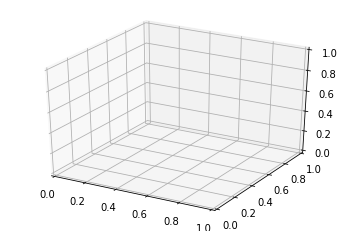

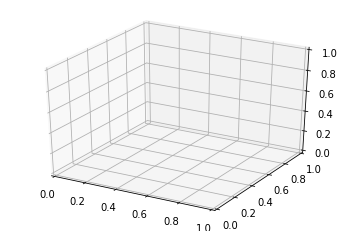

In [332]:
def main(user_id):
    elements, nodes, sections, point_loads, dist_loads, truss_elements = load_data(user_id)

    arranged_dofs, free_dofs, sup_dofs, node_dofs = dofs(nodes)

    local_stifness, transf_arrays, K_ol = stifness_array(dofs, elements, nodes, sections, node_dofs, truss_elements)
    
    point_loads_tr, dist_loads_tr = rotate_loads(elements, point_loads, dist_loads, transf_arrays)

    P_nodal, S, fixed_forces = nodal_forces(point_loads_tr, dist_loads_tr, node_dofs, transf_arrays, arranged_dofs,
                                            elements)

    P_s, D = solver(K_ol, P_nodal, arranged_dofs, arranged_dofs, len(free_dofs), S)

    MQN_nodes, local_displacements = nodal_mqn(local_stifness, transf_arrays, D, elements, node_dofs, S, nodes,
                                               point_loads, fixed_forces)

    MQN_values = mqn_member(elements, MQN_nodes, local_displacements, sections, point_loads_tr, dist_loads_tr)
    #MQN_values.to_csv('model_test/test_1/mqn.csv')
    #pd.DataFrame(D).to_csv('model_test/test_1/displacements.csv')
    d_local, d_global = displ_member(nodes, elements, local_displacements, D, transf_arrays)
    d_local.to_csv('model_test/test_1/d_local.csv', index=None)
    d_global.to_csv('model_test/test_1/d_global.csv', index=None)
    pd.DataFrame(D).to_csv("model_test/test_1/d_global_nodes.csv", index=None)
    print(D)
    return D, nodes, d_local

t1 = time.time()
D, nodes, local_displacements = main('cv13116')
print('Run: ', time.time() - t1)
